In [1]:
import pandas as pd
import numpy as np
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import funciones_tfm as tfm
from sklearn.preprocessing import MinMaxScaler
from utils import load, table_pivot
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
#from lightgbm import LGBMClassifier
import xgboost as xgb
import pickle

In [2]:
df_cluster = load('./data/Cluster_plasma.csv')

In [3]:
lista = ['Sex','Desc', 'Exosome']
table_pivot(df_cluster, lista, lista[0], lista[1:])

Desc    Colorectal Cancer Healthy Control        \
Exosome             True            False True    
Sex                                               
female                 55              30    25   
male                   53              25    39   

Desc    Metastatic renal cell carcinoma (mRCC) Pancreatic Cancer  \
Exosome                                  True              True    
Sex                                                                
female                                      55                54   
male                                        64                63   

Desc    Prostate Cancer chronic fatigue syndrome non-fatigued  
Exosome           True                     False        False  
Sex                                                            
female                0                       55           55  
male                 66                        0            0

# Train/test

**Separo dataframe en train y test**

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_cluster, test_size=0.2, stratify=df_cluster.Desc, random_state=42)

In [5]:
#Guardo dataframe train y test
df_train = train.reset_index(drop=True)
df_test = test.reset_index(drop=True)

**Labelizo**

In [6]:
from sklearn.preprocessing import LabelEncoder

# Crear un LabelEncoder para cada columna
A = LabelEncoder()
B = LabelEncoder()

# Aplicar el LabelEncoder a las columnas
df_train['Sex_L'] = A.fit_transform(df_train['Sex'])
df_train['Exo_L'] = B.fit_transform(df_train['Exosome'])

# Aplicar el LabelEncoder a las columnas
df_test['Sex_L'] = A.fit_transform(df_test['Sex'])
df_test['Exo_L'] = B.fit_transform(df_test['Exosome'])

# Estudio Modelos

In [7]:
X_train, X_test = df_train.iloc[:,5:].values, df_test.iloc[:,5:].values

y_train=df_train.loc[:,'Desc'].values
y_test=df_test.loc[:,'Desc'].values

In [8]:
print(f'Train: \n\tX {X_train.shape} \n\tY {y_train.shape}')
print(f'Test: \n\tX {X_test.shape} \n\tY {y_test.shape}')

Train: 
	X (511, 28) 
	Y (511,)
Test: 
	X (128, 28) 
	Y (128,)


In [9]:
#Carpeta modelo
carpeta='models'
if os.path.exists(carpeta):
    pass
else:
    os.mkdir(carpeta)


subcarpeta='models/plasma'


modelos = {
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {'n_estimators': [200, 300],
                   'max_depth': [12, 16, 18]}
    },
    'SVM': {
        'model': SVC(),
        'params': {'C': [10, 20],
                   'gamma': ['scale', 'auto', 1]}
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(),
        'params': {'n_estimators': [100, 200],
                   #'learning_rate': [0.01, 0.1],
                   #'max_depth': [3, 5]
                  }
    },
    'kNN': {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [2, 3],
                   'weights': ['uniform', 'distance']}
    }
}


mejor_score = 0.0
mejor_clasificador = None
resultados_modelos = []

tamaños = [22,24,26]
#tamaños = [23,24]

for tamaño in tamaños:
    seleccion = list(range(5, tamaño+5)) + [-2, -1]
    X_train, X_test = df_train.iloc[:,seleccion].values, df_test.iloc[:,seleccion].values
    
    y_train=df_train.loc[:,'Desc'].values
    y_test=df_test.loc[:,'Desc'].values
    # validacion cruzada
    for nombre_modelo, mp in modelos.items():
        clf = GridSearchCV(mp['model'], mp['params'], cv=5)
        clf.fit(X_train, y_train)
    
        resultado_modelo = {
            'Modelo': nombre_modelo,
            'Mejor Score': clf.best_score_,
            'Mejores Parámetros': clf.best_params_,
            'Cantidad variables': tamaño
        }
    
        resultados_modelos.append(resultado_modelo)
        print(resultado_modelo)

        #Subcarpeta modelo
        if os.path.exists(subcarpeta):
            pass
        else:
            os.mkdir(subcarpeta)

        archivo_modelo = f'{nombre_modelo}_{tamaño}.pkl'
        # Guardar el mejor modelo en un archivo
        with open(f'./{subcarpeta}/{archivo_modelo}', 'wb') as file:
            pickle.dump(clf, file)
    
        if clf.best_score_ > mejor_score:
            mejor_score = clf.best_score_
            mejor_clasificador = clf

df_resultados = pd.DataFrame(resultados_modelos)


print(f"\nEl mejor modelo es: {mejor_clasificador.best_estimator_} con un score de: {mejor_score}")


archivo_resultados='resultados_plasma_m.csv'

# Guardar resultados
df_resultados.to_csv(f'./{carpeta}/{archivo_resultados}')

{'Modelo': 'RandomForest', 'Mejor Score': 0.898229583095374, 'Mejores Parámetros': {'max_depth': 18, 'n_estimators': 300}, 'Cantidad variables': 22}
{'Modelo': 'SVM', 'Mejor Score': 0.8454978107747954, 'Mejores Parámetros': {'C': 20, 'gamma': 1}, 'Cantidad variables': 22}
{'Modelo': 'GradientBoosting', 'Mejor Score': 0.8591281172663241, 'Mejores Parámetros': {'n_estimators': 200}, 'Cantidad variables': 22}
{'Modelo': 'kNN', 'Mejor Score': 0.8514372739387017, 'Mejores Parámetros': {'n_neighbors': 2, 'weights': 'distance'}, 'Cantidad variables': 22}
{'Modelo': 'RandomForest', 'Mejor Score': 0.9139158576051779, 'Mejores Parámetros': {'max_depth': 16, 'n_estimators': 200}, 'Cantidad variables': 24}
{'Modelo': 'SVM', 'Mejor Score': 0.8611460118027793, 'Mejores Parámetros': {'C': 20, 'gamma': 1}, 'Cantidad variables': 24}
{'Modelo': 'GradientBoosting', 'Mejor Score': 0.8611079383209596, 'Mejores Parámetros': {'n_estimators': 100}, 'Cantidad variables': 24}
{'Modelo': 'kNN', 'Mejor Score': 0.

In [10]:
resultados_sorted = df_resultados[['Modelo', 'Mejor Score', 'Cantidad variables', 'Mejores Parámetros']].sort_values('Mejor Score', ascending=False)
resultados_sorted.reset_index(drop=True, inplace=True)
resultados_sorted.to_csv('./models/Dataframe_modelos_plasma_m.csv', index=False)
resultados_sorted

,Modelo,Mejor Score,Cantidad variables,Mejores Parámetros
0,RandomForest,0.913916,24,"{'max_depth': 16, 'n_estimators': 200}"
1,RandomForest,0.911974,26,"{'max_depth': 12, 'n_estimators': 300}"
2,RandomForest,0.898230,22,"{'max_depth': 18, 'n_estimators': 300}"
3,SVM,0.865068,26,"{'C': 20, 'gamma': 1}"
4,GradientBoosting,0.863050,26,{'n_estimators': 200}
5,SVM,0.861146,24,"{'C': 20, 'gamma': 1}"
6,GradientBoosting,0.861108,24,{'n_estimators': 100}
7,GradientBoosting,0.859128,22,{'n_estimators': 200}
8,kNN,0.851437,22,"{'n_neighbors': 2, 'weights': 'distance'}"
9,SVM,0.845498,22,"{'C': 20, 'gamma': 1}"


## Comparación con otros

In [12]:
resultados_sorted_zm = load('./models/Dataframe_modelos_plasma_z_m.csv', index=False)
resultados_sorted_zm

TypeError: load() got an unexpected keyword argument 'index'

In [13]:
resultados_sorted_log = load('./models/Dataframe_modelos_plasma_log.csv')
resultados_sorted_log

,Modelo,Mejor Score,Cantidad variables,Mejores Parámetros
0,RandomForest,0.903846,23,"{'max_depth': 16, 'n_estimators': 300}"
1,RandomForest,0.901923,24,"{'max_depth': 18, 'n_estimators': 200}"
2,GradientBoosting,0.882692,23,{'n_estimators': 100}
3,GradientBoosting,0.880769,24,{'n_estimators': 100}
4,SVM,0.869231,23,"{'C': 20, 'gamma': 'auto'}"
5,SVM,0.865385,24,"{'C': 20, 'gamma': 'auto'}"
6,kNN,0.851923,23,"{'n_neighbors': 2, 'weights': 'distance'}"
7,kNN,0.851923,24,"{'n_neighbors': 2, 'weights': 'distance'}"


In [11]:
resultados_sorted.iloc[:5,:].values

array([['RandomForest', 0.9139158576051779, 24,
        {'max_depth': 16, 'n_estimators': 200}],
       ['RandomForest', 0.9119741100323624, 26,
        {'max_depth': 12, 'n_estimators': 300}],
       ['RandomForest', 0.898229583095374, 22,
        {'max_depth': 18, 'n_estimators': 300}],
       ['SVM', 0.8650675804302302, 26, {'C': 20, 'gamma': 1}],
       ['GradientBoosting', 0.8630496858937751, 26,
        {'n_estimators': 200}]], dtype=object)

# Evaluación


Classification report:
                                        precision    recall  f1-score   support

                     Colorectal Cancer       0.66      0.95      0.78        22
                       Healthy Control       0.93      0.58      0.72        24
Metastatic renal cell carcinoma (mRCC)       1.00      1.00      1.00        24
                     Pancreatic Cancer       1.00      1.00      1.00        23
                       Prostate Cancer       0.92      0.85      0.88        13
              chronic fatigue syndrome       1.00      1.00      1.00        11
                          non-fatigued       1.00      1.00      1.00        11

                              accuracy                           0.90       128
                             macro avg       0.93      0.91      0.91       128
                          weighted avg       0.92      0.90      0.90       128



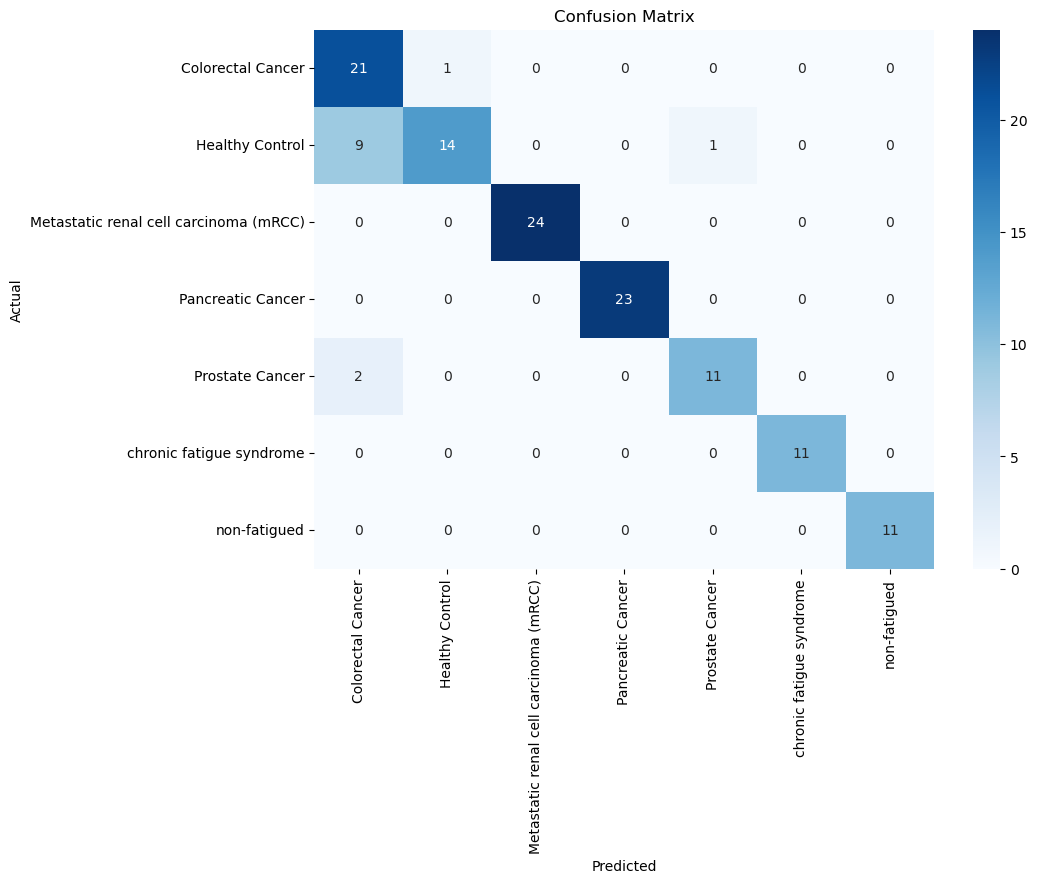

In [9]:
#Subcarpeta modelo
subcarpeta_figuras='figures/plasma'
if os.path.exists(subcarpeta_figuras):
    pass
else:
    os.mkdir(subcarpeta_figuras)

subcarpeta='models/plasma'
nombre_modelo = 'RandomForest'
tamaño = 24

#Selecciono modelo
archivo = f'{nombre_modelo}_{tamaño}.pkl'

#Creo train/test
seleccion = list(range(5, tamaño+5)) + [-2, -1]

X_test = df_test.iloc[:,seleccion].values
y_test=df_test.loc[:,'Desc'].values


# Cargo el modelo desde la carpeta
with open(f'./{subcarpeta}/{archivo}', 'rb') as file:
    mejor_clasificador = pickle.load(file)
    
# Predicción con los datos de prueba
y_pred = mejor_clasificador.predict(X_test)

# informe de clasificación
print("\nClassification report:")
print(classification_report(y_test, y_pred))

# Calcula la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

features_conf = np.unique(y_test)
cm_df = pd.DataFrame(cm, index=[f'{i}' for i in features_conf ], columns=[f'{i}' for i in features_conf ])

# Muestra y guarda la matriz de confusión
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(f'./{subcarpeta_figuras}/matriz_confusion.png', bbox_inches='tight')
plt.show()

In [16]:
print(f'Características necesarias para la predicción SIN ORDENAR: {df_test.iloc[:,seleccion].columns.tolist()}')

Características necesarias para la predicción SIN ORDENAR: ['hsa-miR-6892-5p', 'hsa-miR-4753-5p', 'hsa-miR-124-3p', 'hsa-miR-2116-3p', 'hsa-miR-3940-3p', 'hsa-miR-384', 'hsa-miR-4433b-3p', 'hsa-miR-5100', 'hsa-miR-23b-3p', 'hsa-miR-9985', 'hsa-miR-5193', 'hsa-let-7f-5p', 'hsa-miR-6866-5p', 'hsa-miR-4508', 'hsa-miR-3150a-5p', 'hsa-miR-500a-3p', 'hsa-miR-4443', 'hsa-miR-1306-5p', 'hsa-miR-425-3p', 'hsa-miR-758-5p', 'hsa-miR-363-5p', 'hsa-miR-4799-5p', 'hsa-miR-144-5p', 'hsa-miR-216a-3p', 'Sex_L', 'Exo_L']


In [15]:
print(f'Características necesarias para la predicción: {sorted(df_test.iloc[:,seleccion].columns.tolist())}')

Características necesarias para la predicción: ['Exo_L', 'Sex_L', 'hsa-let-7f-5p', 'hsa-miR-124-3p', 'hsa-miR-1306-5p', 'hsa-miR-144-5p', 'hsa-miR-2116-3p', 'hsa-miR-216a-3p', 'hsa-miR-23b-3p', 'hsa-miR-3150a-5p', 'hsa-miR-363-5p', 'hsa-miR-384', 'hsa-miR-3940-3p', 'hsa-miR-425-3p', 'hsa-miR-4433b-3p', 'hsa-miR-4443', 'hsa-miR-4508', 'hsa-miR-4753-5p', 'hsa-miR-4799-5p', 'hsa-miR-500a-3p', 'hsa-miR-5100', 'hsa-miR-5193', 'hsa-miR-6866-5p', 'hsa-miR-6892-5p', 'hsa-miR-758-5p', 'hsa-miR-9985']


In [17]:
def ROC_and_Plot (X_test,y_test, nombre_modelo, tamaño):
    # Crear una instancisa de OneHotEncoder
    encoder = OneHotEncoder()
    y_test_enc=encoder.fit_transform(y_test.reshape(-1,1)).toarray()
    
    # Obtener las puntuaciones predichas
    try:
        y_score = mejor_clasificador.predict_proba(X_test) # RandomForest
    except:
        y_score = mejor_clasificador.decision_function(X_test) # SVM
    
    # Calcular la curva ROC y el AUC para cada clase
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(y_test_enc.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_test_enc[:, i], y_score[:, i])
        roc_auc[i] = roc_auc_score(y_test_enc[:, i], y_score[:, i])
    
    
    # Calcular la ROC y el AUC para micro-promedio
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_enc.ravel(), y_score.ravel())
    roc_auc["micro"] = roc_auc_score(y_test_enc, y_score, average='micro')

    # Crea una figura para las curvas ROC
    plt.figure(figsize=(10, 8))
    
    # Define los colores para cada clase
    colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'])
    
    dict = {}
    for x, j in enumerate(np.unique(y_test)):
        dict[x] = j
    
    # Dibuja la curva ROC para cada clase
    for i, color in zip(range(y_test_enc.shape[1]), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve ({dict[i]}) (area = {roc_auc[i]:.2f})')
    
    # Dibuja la curva ROC micro-promediada
    plt.plot(fpr["micro"], tpr["micro"], color='darkorange', linestyle=':', linewidth=4,
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})')
    
    # Añade la diagonal que representa una clasificación aleatoria
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    
    # Añadir etiquetas y título
    # Guarda las curvas ROC
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curvas ({nombre_modelo}_{tamaño})')
    plt.legend(loc="lower right")
    plt.savefig(f'./{subcarpeta_figuras}/ROC_{nombre_modelo}_{tamaño}.png', bbox_inches='tight')
    
    
    # Muestra la gráfica
    plt.show()

    return fpr, tpr, roc_auc

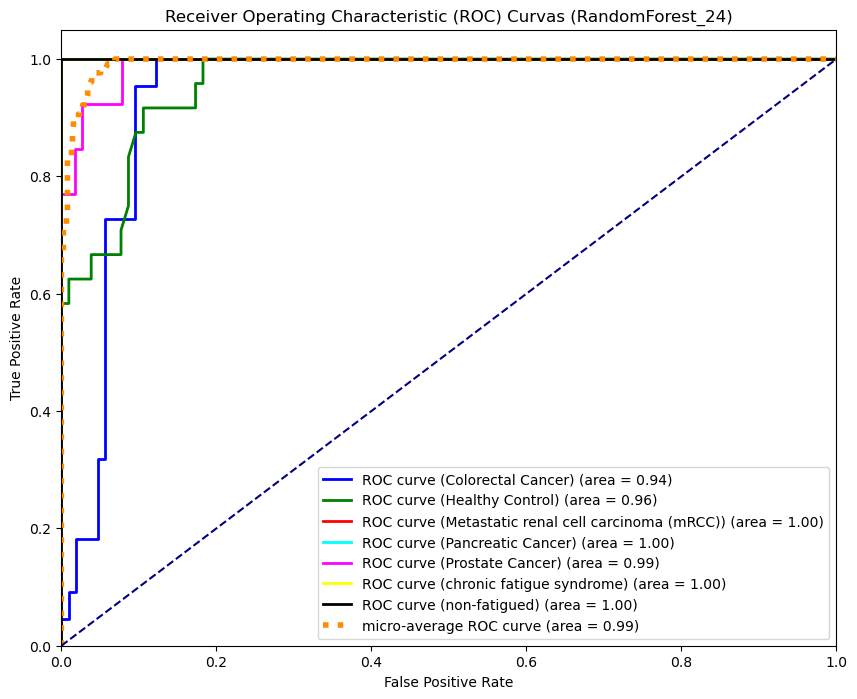

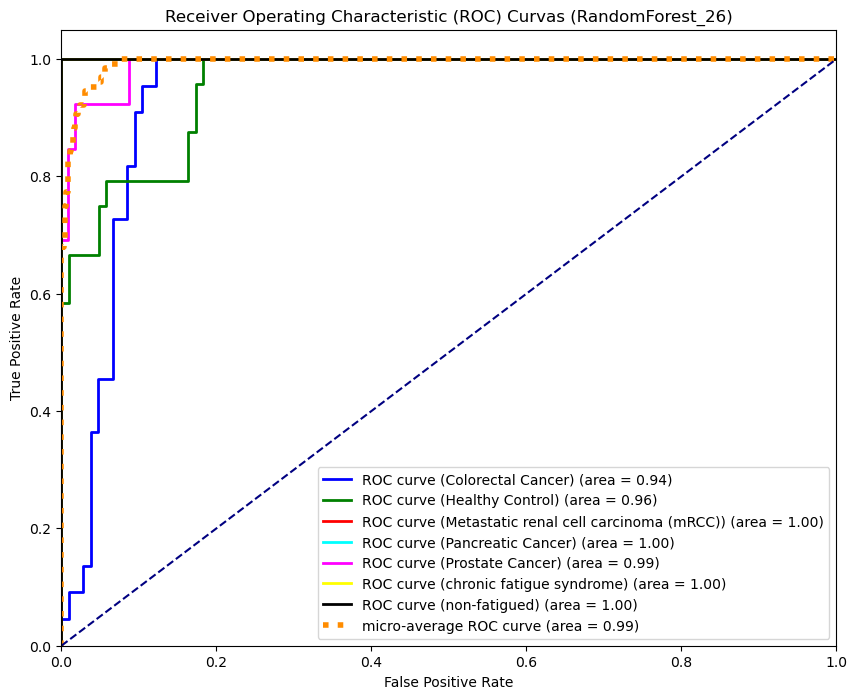

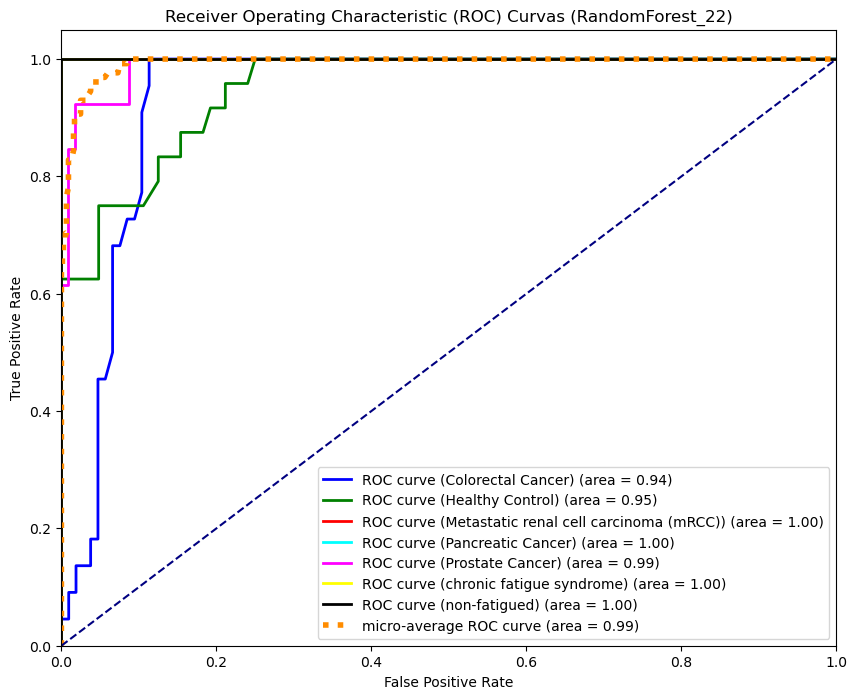

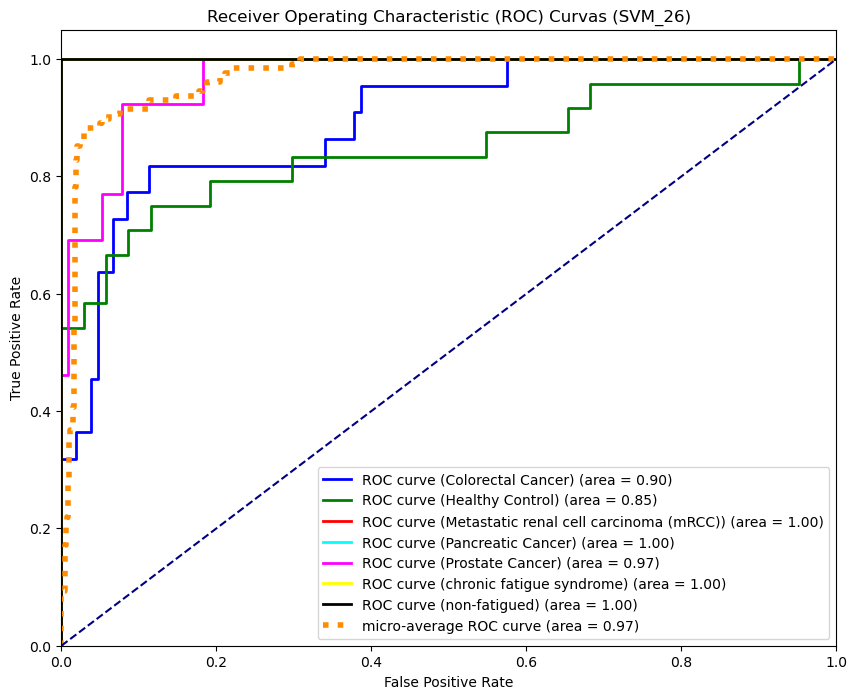

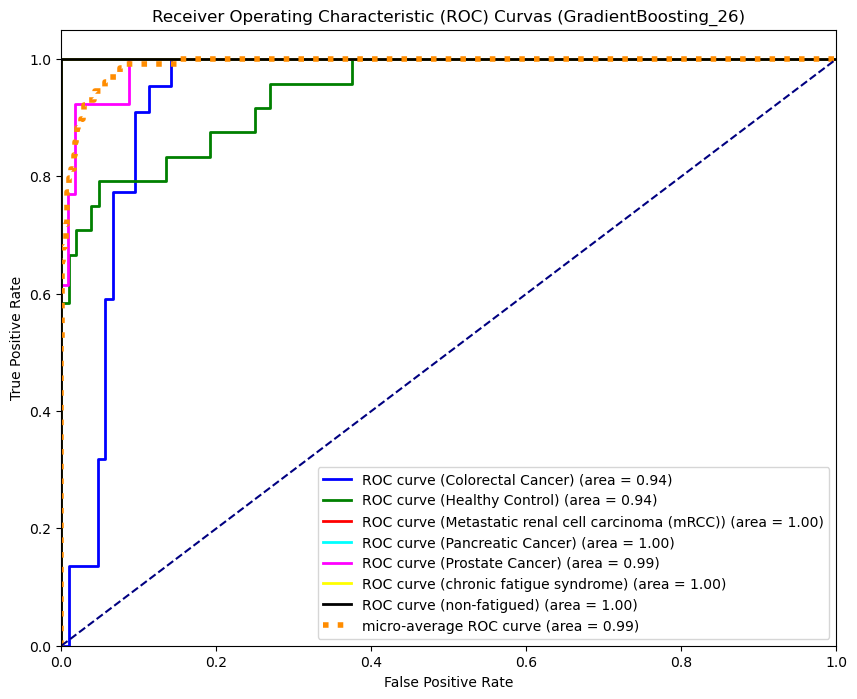

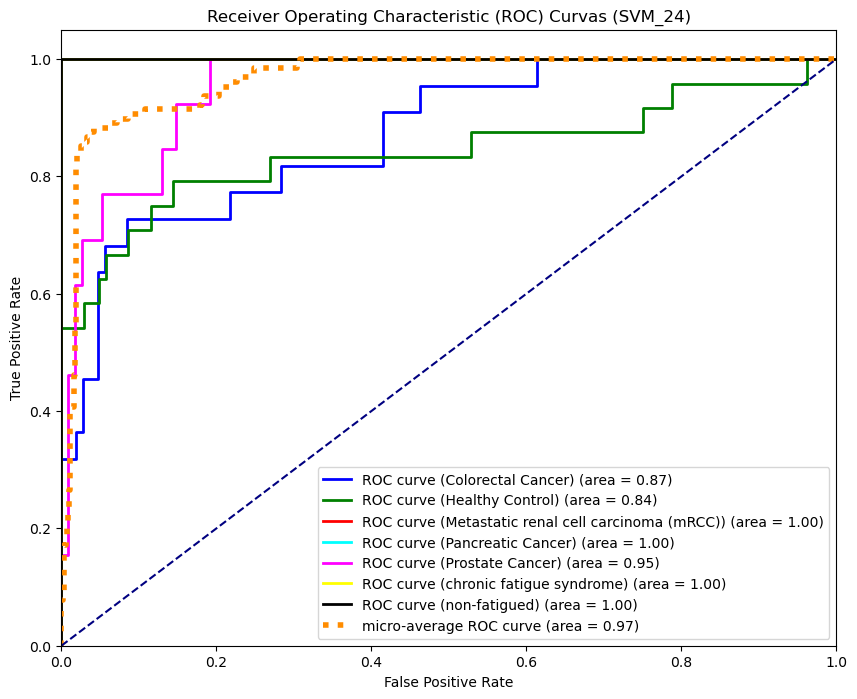

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder
from itertools import cycle

#Subcarpeta modelo
subcarpeta_figuras='figures/plasma'

resultados_sorted = load('./models/Dataframe_modelos_plasma_m.csv')
for row in range(int(len(resultados_sorted)/2)):
    subcarpeta='models/plasma'
    nombre_modelo = resultados_sorted.loc[row,'Modelo']
    tamaño = resultados_sorted.loc[row,'Cantidad variables']
    
    #Selecciono modelo
    archivo = f'{nombre_modelo}_{tamaño}.pkl'
    
    #Creo train/test
    seleccion = list(range(5, tamaño+5))  + [-2, -1]
    
    X_test = df_test.iloc[:,seleccion].values
    y_test=df_test.loc[:,'Desc'].values
    
    
    # Cargo el modelo desde la carpeta
    with open(f'./{subcarpeta}/{archivo}', 'rb') as file:
        mejor_clasificador = pickle.load(file)

    _,_,_ = ROC_and_Plot (X_test, y_test, nombre_modelo, tamaño)

# Importancia de las variables

## A través de los modelos de entrenamiento

In [19]:
resultados_sorted = load('./models/Dataframe_modelos_plasma_m.csv')

features = list(df_test.iloc[:,5:].columns)

frequenceFeatures = {}
for feature in features:
    frequenceFeatures[feature] = 0

contador = 0

for row in range(len(resultados_sorted)):
    subcarpeta='models/plasma'
    nombre_modelo = resultados_sorted.loc[row, 'Modelo']
    tamaño = resultados_sorted.loc[row, 'Cantidad variables']
    
    #Selecciono modelo
    archivo = f'{nombre_modelo}_{tamaño}.pkl'
    
    
    #Creo train/test
    seleccion = list(range(5, tamaño+5)) + [-2, -1]
    
    X_test = df_test.iloc[:,seleccion].values
    y_test=df_test.loc[:,'Desc'].values
    
    
    # Cargo el modelo desde la carpeta
    with open(f'./{subcarpeta}/{archivo}', 'rb') as file:
        mejor_clasificador = pickle.load(file)

    mejor_estimador =  mejor_clasificador.best_estimator_

    try:
        
        df_importance = pd.DataFrame({'Attributes': df_test.iloc[:,seleccion].columns ,'Importances': mejor_estimador.feature_importances_})
        more_importances = df_importance.sort_values('Importances', ascending=False)[:15]['Attributes'].values
        
        for attribute in more_importances:
            frequenceFeatures[attribute] += 1
            
        print(f'{nombre_modelo} {tamaño}: \tSi se ha calculado\n')
        contador += 1
        
    except:
        pass

print(f'Cantidad de modelos utilizados para hallar la importancia: {contador}')

RandomForest 24: 	Si se ha calculado

RandomForest 26: 	Si se ha calculado

RandomForest 22: 	Si se ha calculado

GradientBoosting 26: 	Si se ha calculado

GradientBoosting 24: 	Si se ha calculado

GradientBoosting 22: 	Si se ha calculado

Cantidad de modelos utilizados para hallar la importancia: 6


In [20]:
keyAttributes = [key for key, value in frequenceFeatures.items() if value == contador]
keyAttributes

['hsa-miR-124-3p',
 'hsa-miR-384',
 'hsa-miR-4433b-3p',
 'hsa-miR-5100',
 'hsa-miR-23b-3p',
 'hsa-let-7f-5p',
 'hsa-miR-4508',
 'hsa-miR-500a-3p',
 'hsa-miR-4443',
 'hsa-miR-758-5p']

C:\Users\eagle\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


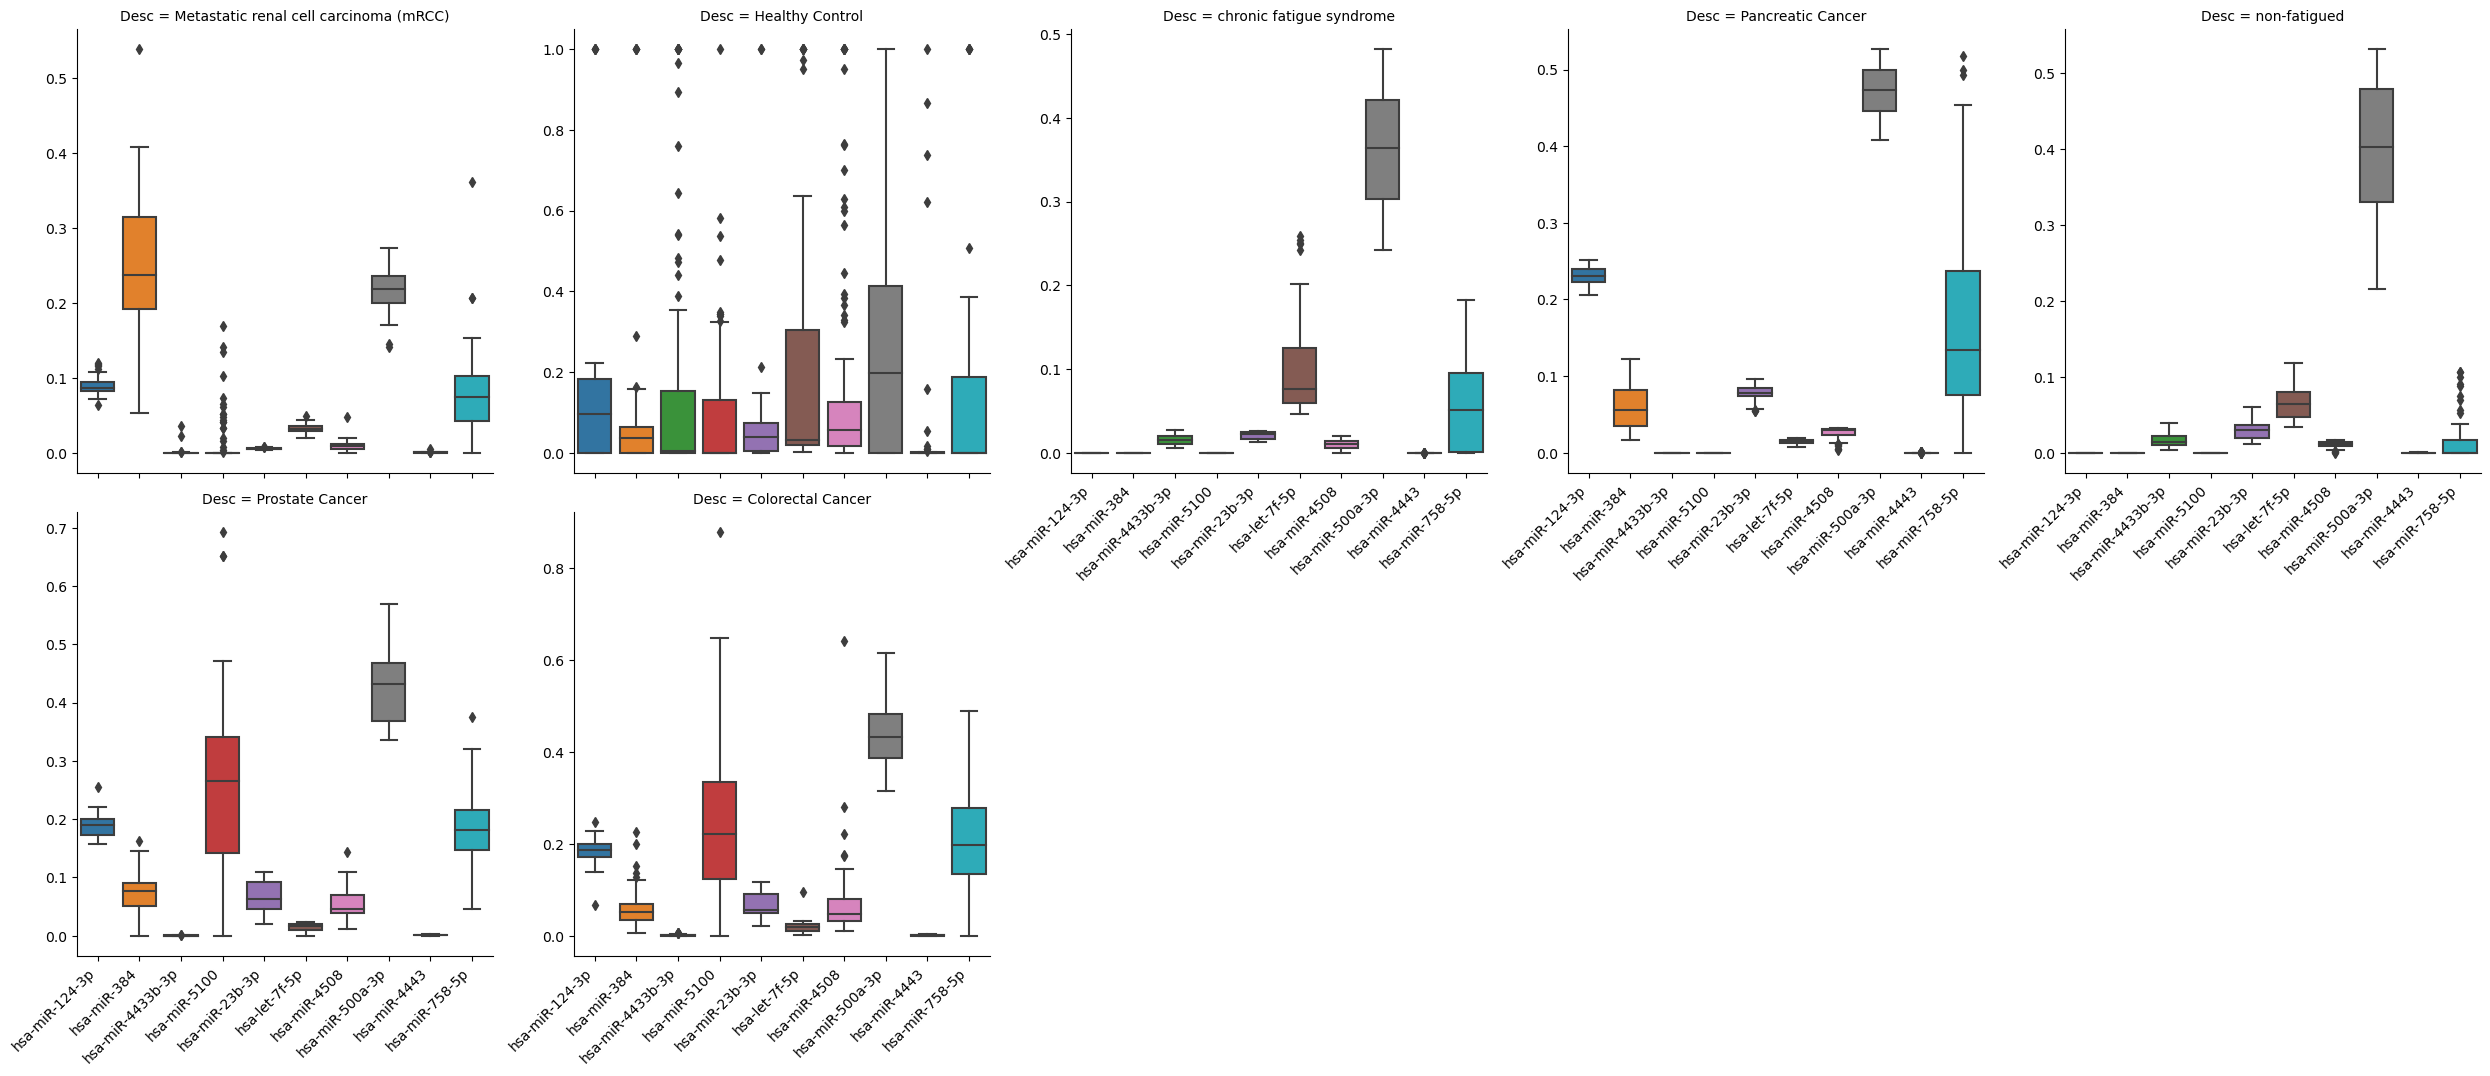

In [21]:
g = sns.catplot(df_train[keyAttributes + ['Desc', 'Sex']], kind='box',col='Desc',col_wrap=5, orient='v', sharey=False)
#g.fig.suptitle(f'Boxplot for Sex: {sex}', y=1)

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')  # Opcional: para alinear mejor las etiquetas

plt.savefig(f'./{subcarpeta_figuras}/boxplot_most_importance_features.png', bbox_inches='tight')
plt.show()

## A través de Volcano Plot

In [10]:
import scikit_posthocs as sp

# Separar las características y la variable objetivo
X = df_cluster.iloc[:,4:].drop('Desc', axis=1)
y = df_cluster['Desc']

# Lista para almacenar los resultados de las pruebas de Dunn
dunn_results = {}

for column in X.columns:
    # Combinar X y y en un DataFrame para la prueba de Dunn
    data = pd.DataFrame({
        'values': X[column],
        'group': y
    })
    
    # Aplicar la prueba de Dunn con ajuste de Bonferroni para comparaciones múltiples
    dunn_result = sp.posthoc_dunn(data, val_col='values', group_col='group', p_adjust='bonferroni')
    
    # Almacenar el resultado de la prueba de Dunn
    dunn_results[column] = dunn_result

In [11]:
from itertools import combinations

# Lista de todas las combinaciones de pares de grupos de 'Desc'
group_pairs = list(combinations(y.unique(), 2))

# Diccionario para almacenar los resultados de log2FC y p-values para cada grupo
log2fc_results = {}
p_values_dunn = {}

# Para cada par de grupos, calcular log2FC y los p-values
for group1, group2 in group_pairs:
    # Filtrar los datos por los dos grupos a comparar
    mask = (y == group1) | (y == group2)
    X_filtered = X[mask]
    y_filtered = y[mask]

    # Inicializar diccionarios para almacenar los resultados de esta comparación de grupos
    log2fc_results[f'{group1} vs {group2}'] = []
    p_values_dunn[f'{group1} vs {group2}'] = []

    # Aplicar prueba de Dunn para cada característica
    for column in X.columns:
        # Calcular la media por grupo
        group_means = X_filtered.groupby(y_filtered)[column].mean()

        # Calcular log2 Fold Change
        fold_change = group_means[group2] / group_means[group1]
        log2fc = np.log2(fold_change)
        log2fc_results[f'{group1} vs {group2}'].append(log2fc)

        # Aplicar la prueba de Dunn
        data = pd.DataFrame({
            'values': X_filtered[column],
            'group': y_filtered
        })

        # Aplicar la prueba de Dunn con ajuste Bonferroni
        dunn_result = sp.posthoc_dunn(data, val_col='values', group_col='group', p_adjust='bonferroni')

        # Obtener el p-value de la comparación entre group1 y group2
        p_value = dunn_result.loc[group1, group2]
        p_values_dunn[f'{group1} vs {group2}'].append(p_value)

C:\Users\eagle\AppData\Local\Temp\ipykernel_12732\2026820869.py:28: RuntimeWarning: divide by zero encountered in log2
  log2fc = np.log2(fold_change)
C:\Users\eagle\AppData\Local\Temp\ipykernel_12732\2026820869.py:28: RuntimeWarning: divide by zero encountered in log2
  log2fc = np.log2(fold_change)
C:\Users\eagle\AppData\Local\Temp\ipykernel_12732\2026820869.py:28: RuntimeWarning: divide by zero encountered in log2
  log2fc = np.log2(fold_change)
C:\Users\eagle\AppData\Local\Temp\ipykernel_12732\2026820869.py:28: RuntimeWarning: divide by zero encountered in log2
  log2fc = np.log2(fold_change)
C:\Users\eagle\AppData\Local\Temp\ipykernel_12732\2026820869.py:28: RuntimeWarning: divide by zero encountered in log2
  log2fc = np.log2(fold_change)
C:\Users\eagle\AppData\Local\Temp\ipykernel_12732\2026820869.py:27: RuntimeWarning: invalid value encountered in scalar divide
  fold_change = group_means[group2] / group_means[group1]
C:\Users\eagle\anaconda3\Lib\site-packages\scikit_posthocs\_

posx and posy should be finite values
C:\Users\eagle\anaconda3\Lib\site-packages\matplotlib\transforms.py:365: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 0] - points[0, 0]
posx and posy should be finite values


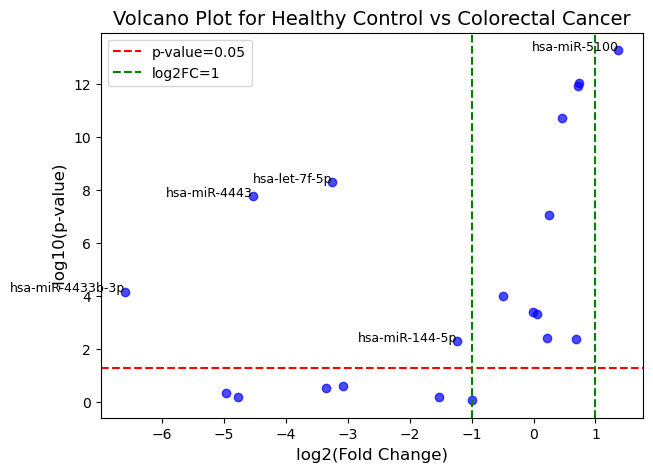

posx and posy should be finite values
posx and posy should be finite values


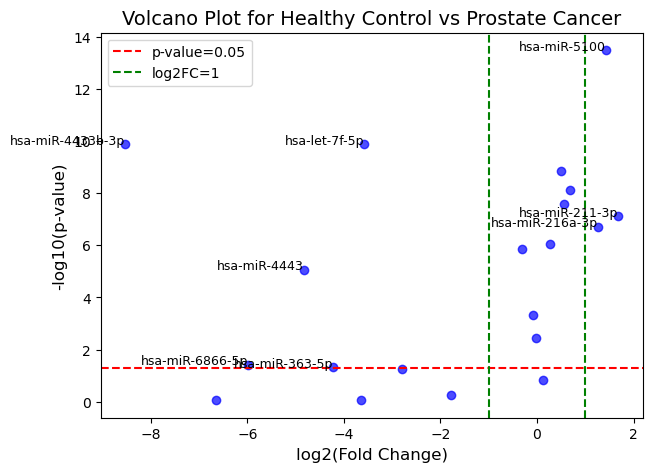

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


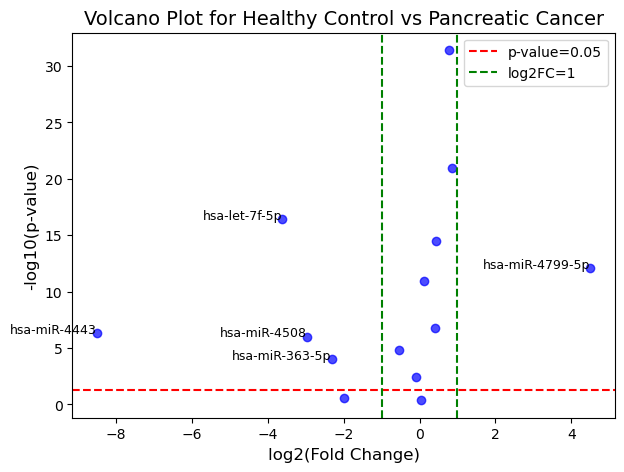

posx and posy should be finite values
posx and posy should be finite values


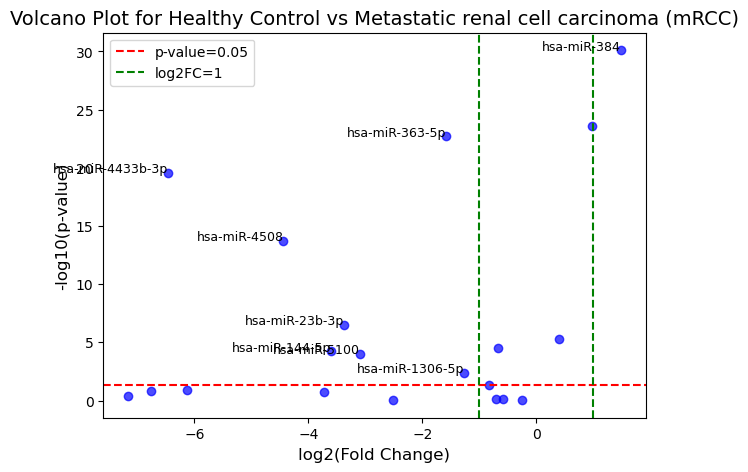

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


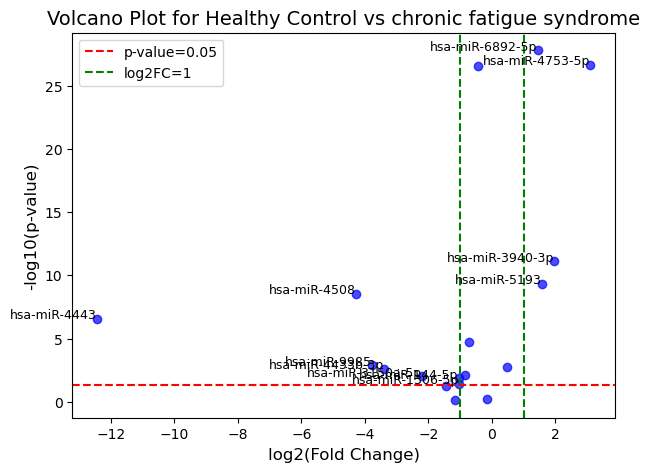

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


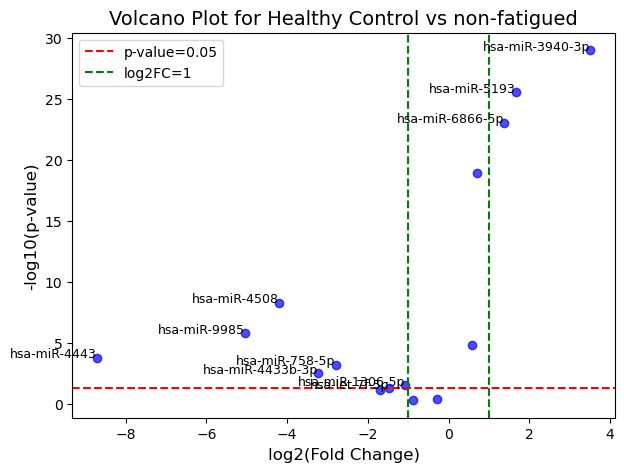

posx and posy should be finite values
posx and posy should be finite values


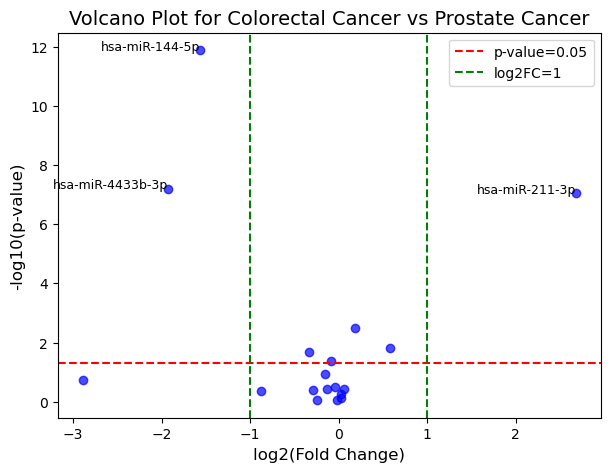

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


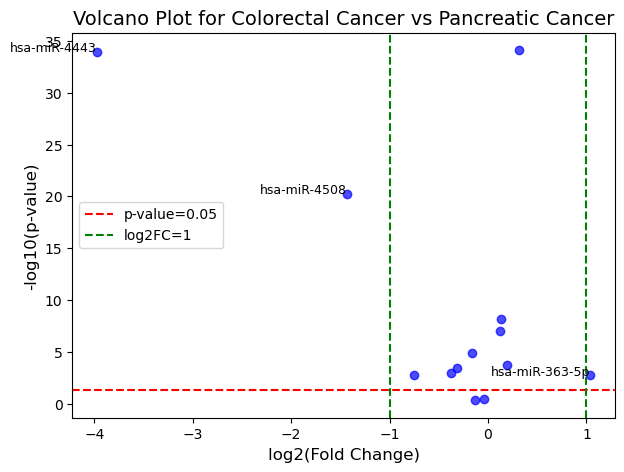

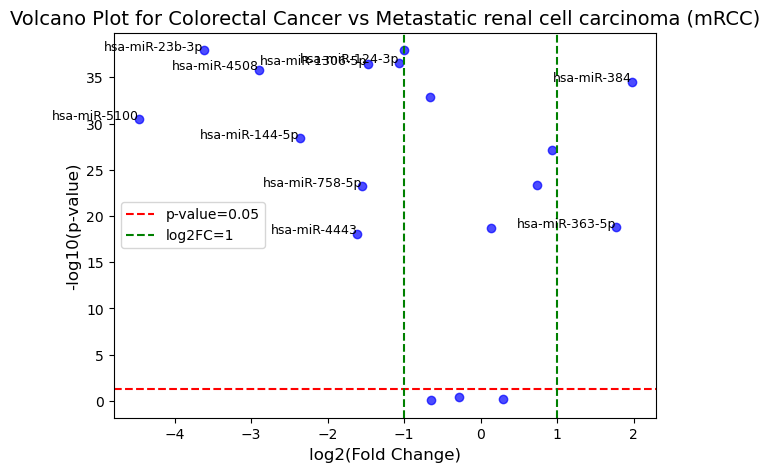

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


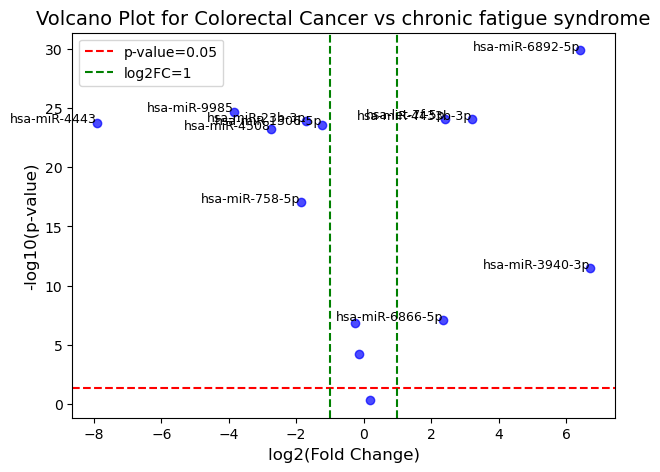

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


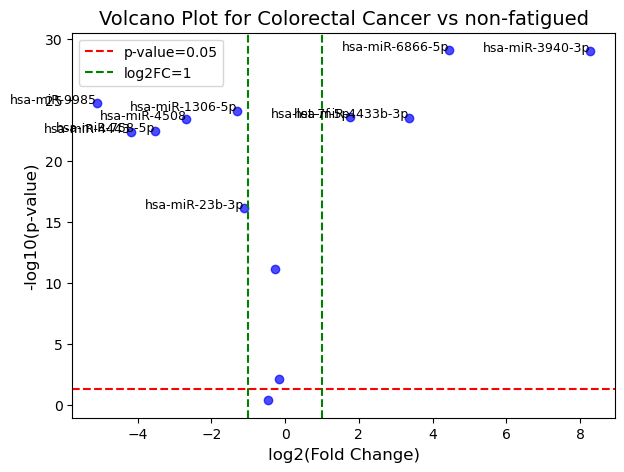

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


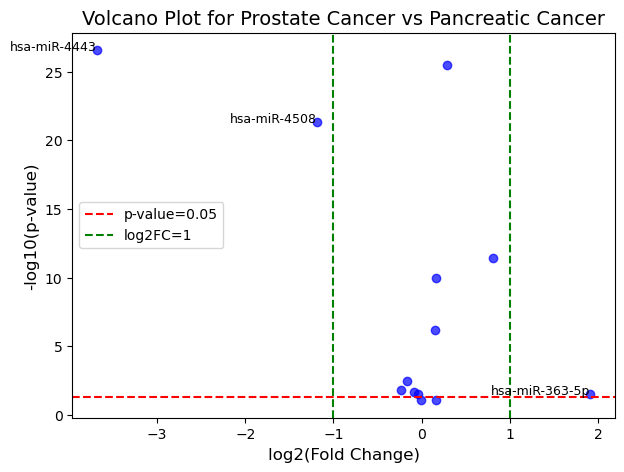

posx and posy should be finite values
posx and posy should be finite values


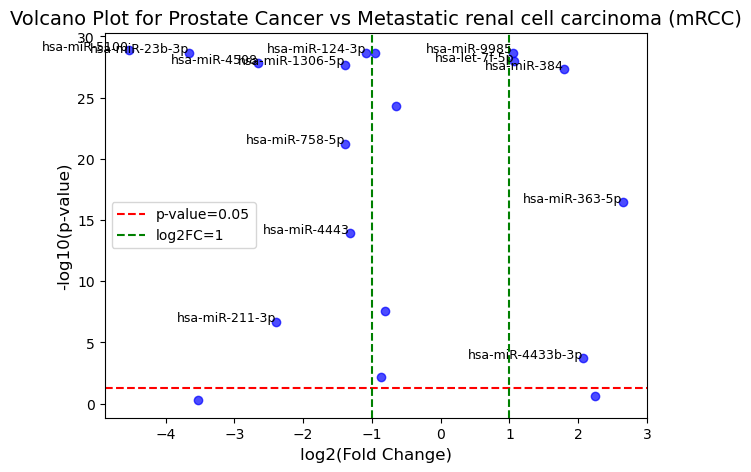

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


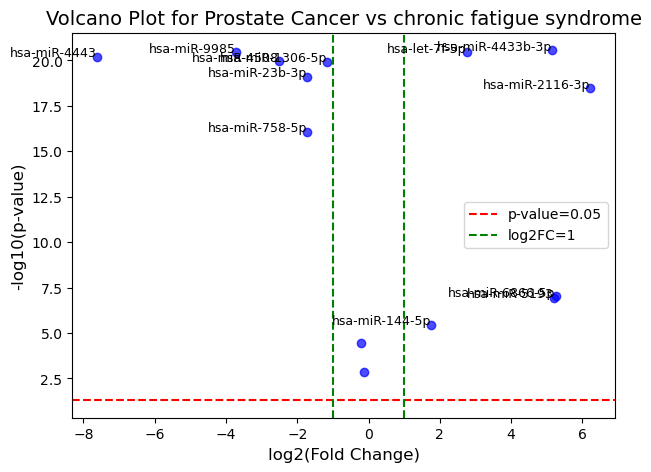

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


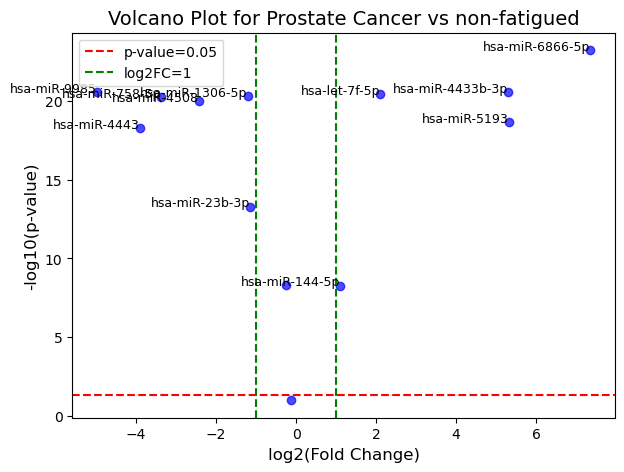

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


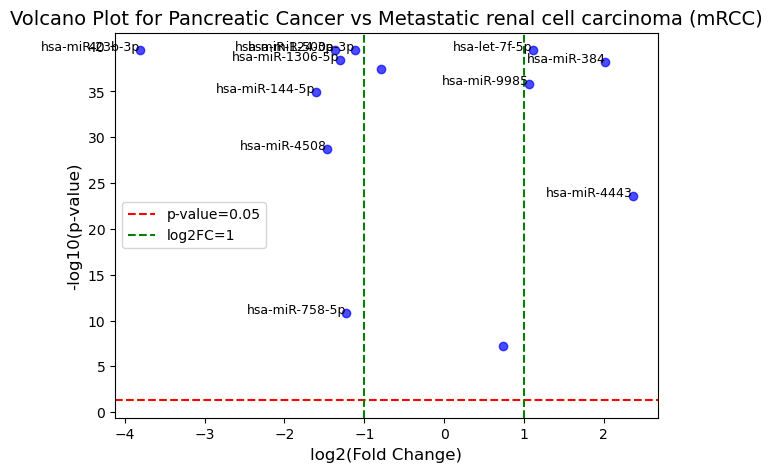

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


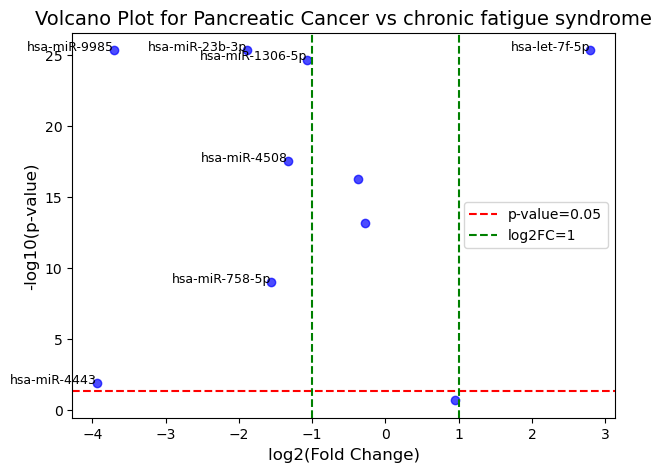

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


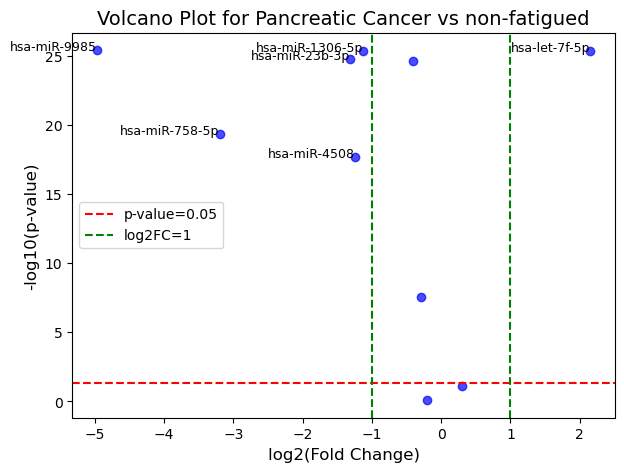

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


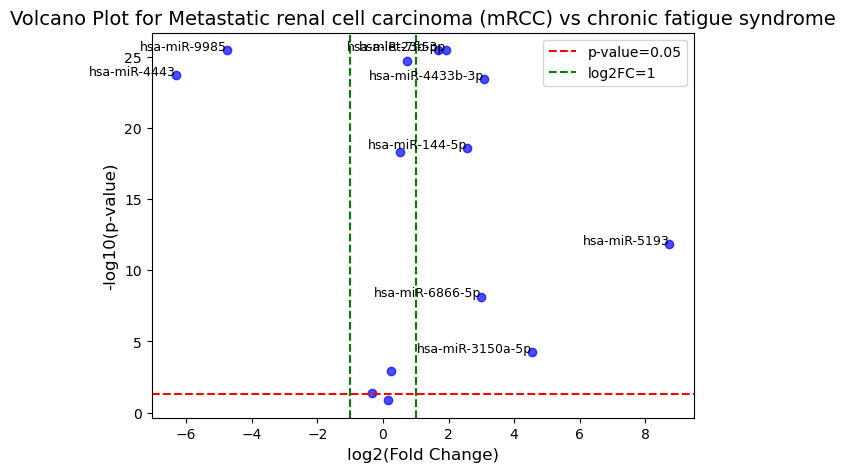

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


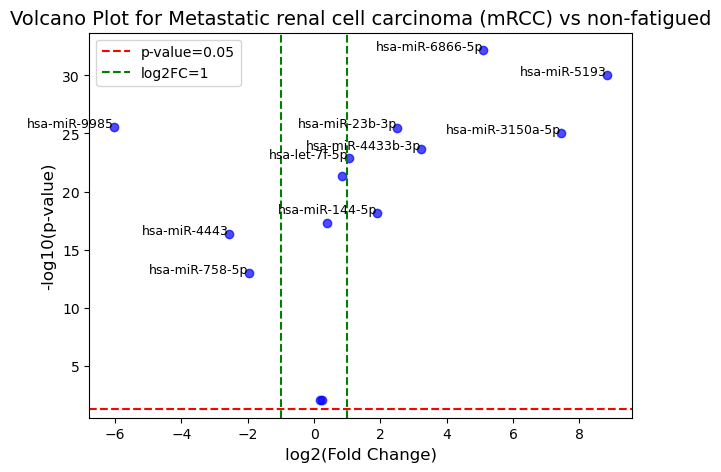

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


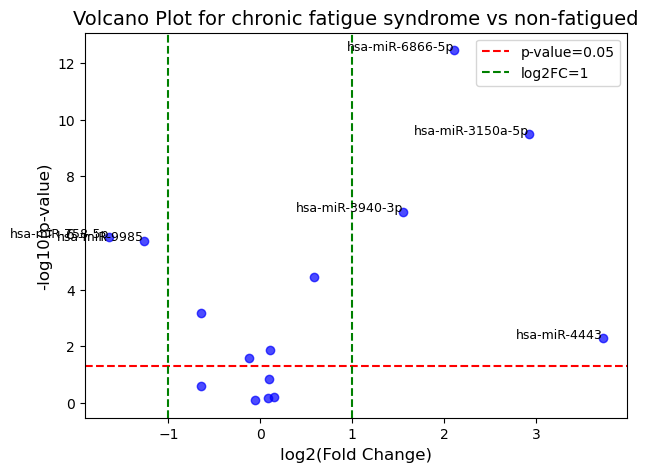

In [12]:
# Umbrales para el volcano plot
p_value_threshold = 0.05
fold_change_threshold = 1  # log2FC > 1 o < -1

# Generar volcano plots para cada par de grupos
for group_pair in log2fc_results.keys():
    log2fc_values = log2fc_results[group_pair]
    p_values = p_values_dunn[group_pair]

    # Crear el plot
    plt.figure(figsize=(7, 5))

    # Convertir p-values en -log10(p-values)
    log_p_values = -np.log10(p_values)

    # Graficar los puntos (log2FC vs -log10(p-value))
    plt.scatter(log2fc_values, log_p_values, color='blue', alpha=0.7)

    # Añadir líneas de corte
    plt.axhline(y=-np.log10(p_value_threshold), color='red', linestyle='--', label=f'p-value={p_value_threshold}')
    plt.axvline(x=fold_change_threshold, color='green', linestyle='--', label=f'log2FC={fold_change_threshold}')
    plt.axvline(x=-fold_change_threshold, color='green', linestyle='--')

    # Etiquetar los puntos más significativos
    for i, txt in enumerate(X.columns):
        if (log_p_values[i] > -np.log10(p_value_threshold)) and (abs(log2fc_values[i]) > fold_change_threshold):
            plt.text(log2fc_values[i], log_p_values[i], txt, fontsize=9, ha='right')

    # Configurar el título y etiquetas
    plt.title(f'Volcano Plot for {group_pair}', fontsize=14)
    plt.xlabel('log2(Fold Change)', fontsize=12)
    plt.ylabel('-log10(p-value)', fontsize=12)
    plt.legend()

    # Mostrar el plot
    plt.show()

C:\Users\eagle\AppData\Local\Temp\ipykernel_12732\4162228741.py:26: RuntimeWarning: divide by zero encountered in log2
  log2fc = np.log2(mean_group_1 / mean_group_rest) if mean_group_rest != 0 else np.nan


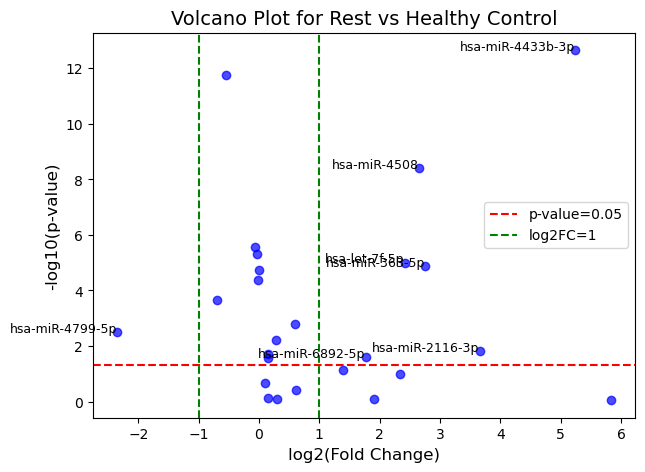

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


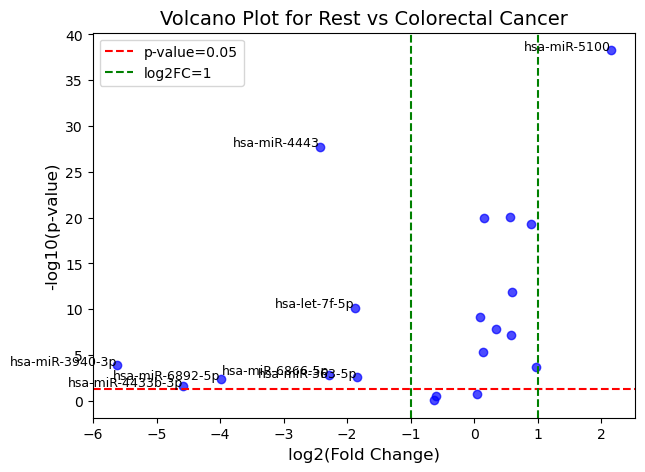

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


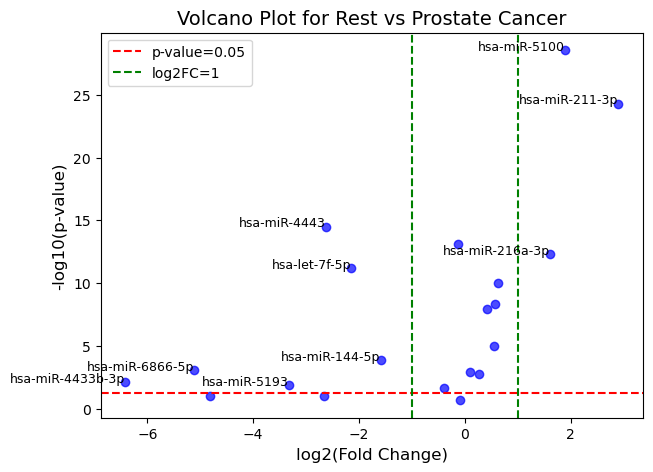

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

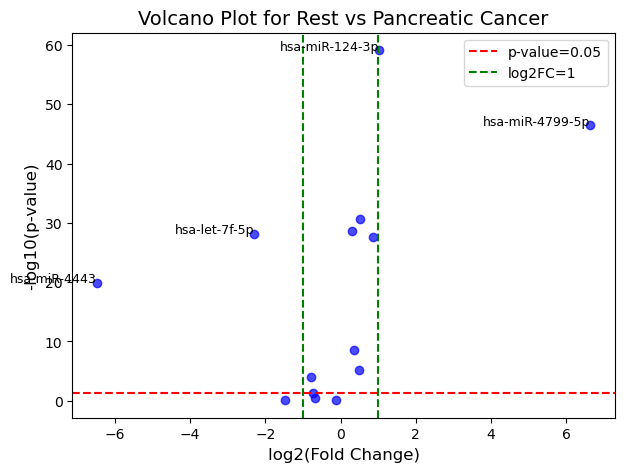

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


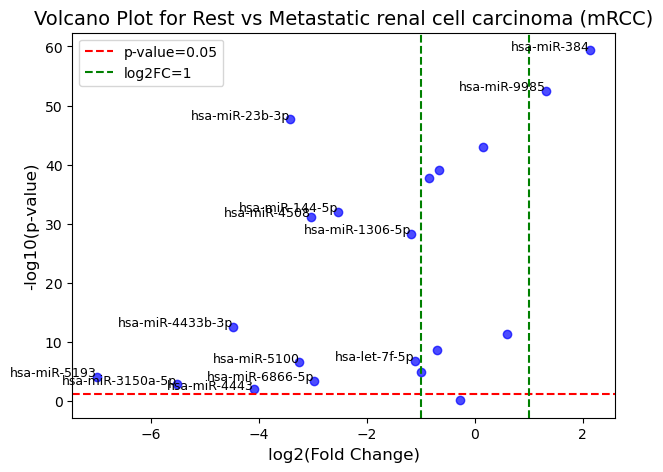

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

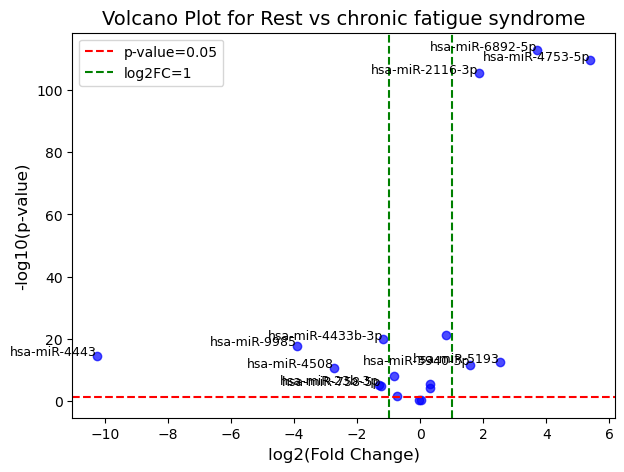

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

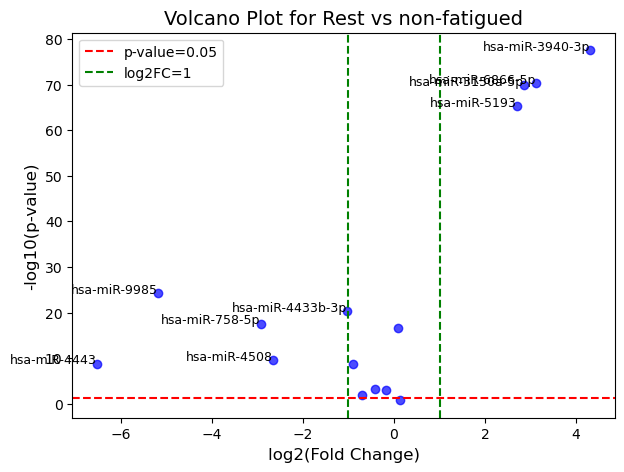

In [13]:
from scipy.stats import kruskal

# Parámetros para el volcano plot
p_value_threshold = 0.05
fold_change_threshold = 1  # log2FC > 1 o < -1

# Lista para almacenar resultados de log2FC y p-values
log2fc_results = {}
p_values_dunn = {}

# Comparar cada valor de Desc con el resto
for value in y.unique():
    # Separar los grupos
    group_1 = X[y == value]
    group_rest = X[y != value]

    log2fc_list = []
    p_values_list = []

    for column in X.columns:
        # Calcular la media para group_1 y el resto
        mean_group_1 = group_1[column].mean()
        mean_group_rest = group_rest[column].mean()

        # Calcular log2 Fold Change
        log2fc = np.log2(mean_group_1 / mean_group_rest) if mean_group_rest != 0 else np.nan
        log2fc_list.append(log2fc)

        # Prueba de Kruskal-Wallis (o Dunn si se prefiere)
        samples = [group_1[column], group_rest[column]]
        _, p_value = kruskal(*samples)
        p_values_list.append(p_value)

    # Almacenar resultados
    log2fc_results[value] = np.array(log2fc_list)
    p_values_dunn[value] = np.array(p_values_list)

    # Crear volcano plot para esta comparación (un valor contra todos)
    plt.figure(figsize=(7, 5))

    # Convertir p-values en -log10(p-values)
    log_p_values = -np.log10(p_values_list)

    # Graficar los puntos (log2FC vs -log10(p-value))
    plt.scatter(log2fc_list, log_p_values, color='blue', alpha=0.7)

    # Añadir líneas de corte
    plt.axhline(y=-np.log10(p_value_threshold), color='red', linestyle='--', label=f'p-value={p_value_threshold}')
    plt.axvline(x=fold_change_threshold, color='green', linestyle='--', label=f'log2FC={fold_change_threshold}')
    plt.axvline(x=-fold_change_threshold, color='green', linestyle='--')

    # Etiquetar los puntos más significativos
    for i, txt in enumerate(X.columns):
        if (log_p_values[i] > -np.log10(p_value_threshold)) and (abs(log2fc_list[i]) > fold_change_threshold):
            plt.text(log2fc_list[i], log_p_values[i], txt, fontsize=9, ha='right')

    # Configurar el título y etiquetas
    plt.title(f'Volcano Plot for Rest vs {value}', fontsize=14)
    plt.xlabel('log2(Fold Change)', fontsize=12)
    plt.ylabel('-log10(p-value)', fontsize=12)
    plt.legend()

    # Mostrar el plot
    plt.savefig(f'./{subcarpeta_figuras}/volcanoplot_{value}.png', bbox_inches='tight')
    plt.show()

C:\Users\eagle\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


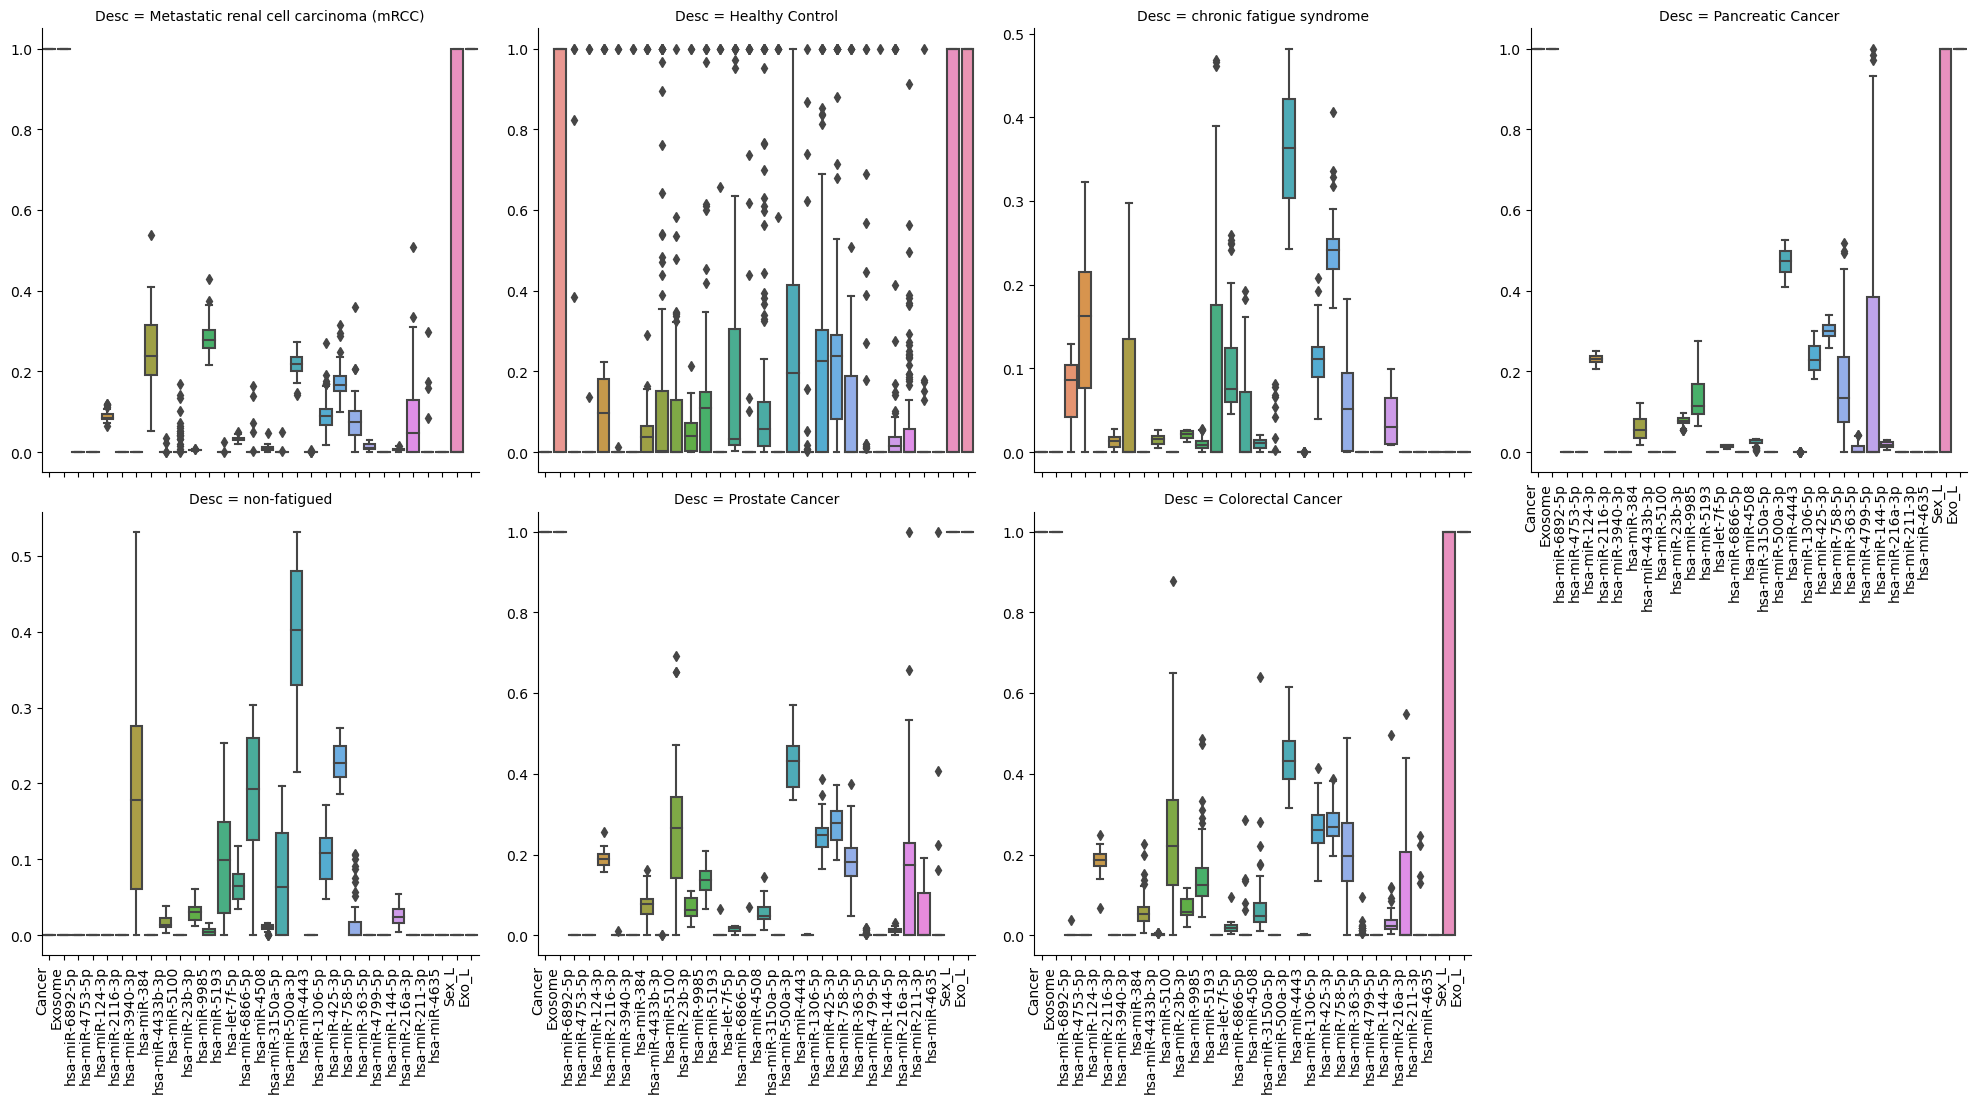

In [25]:
g = sns.catplot(df_train, kind='box',col='Desc',col_wrap=4, orient='v', sharey=False)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        label.set_ha('right')  # Opcional: para alinear mejor las etiquetas
plt.show()